In [4]:
import numpy as np
import scipy.fft as fft
import scipy.optimize
import matplotlib.pyplot as plt
import pickle

In [3]:
# Setting up the signal
F_s =1e6
T = 1/F_s
f_0 = 1e5
omega_0 = 2*np.pi*f_0
phi = np.pi/8
A = 1

N = 513
n_0 = -256
t = np.arange(n_0, n_0+N)*T

SNR_db = np.arange(-10, 70, 10)
SNR_num = 10**(SNR_db/10)

ks = np.arange(10,22,2)
M = 2**ks

repetition = np.arange(200)
sample = np.arange(N)

#1a)
omega_vars = np.zeros((len(SNR_db), len(M)))
phi_vars = np.zeros((len(SNR_db), len(M)))

# for i, SNR in enumerate(SNR_num):
#     for j, m in enumerate(M):
#         temp_omega = np.zeros(100)
#         temp_phi = np.zeros(100)
#         for k in range(100):
#             noise_real = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)
#             noise_complex = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)*1j
#             signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
#             F = fft.fft(signal, n=m, norm='ortho')
#             m_star = np.argmax(np.abs(F))
#             omega_hat = 2*np.pi*m_star/(m*T)
#             phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
#             temp_omega[k] = omega_hat- omega_0
#             temp_phi[k] = phi_hat - phi # Fixes wrapping
#         print('SNR: ', SNR_db[i], 'M: ', m, 'omega: ', np.var(temp_omega, ddof=1), 'phi: ', np.var(temp_phi, ddof=1))
#         omega_vars[i,j] = np.var(temp_omega, ddof=1)
#         phi_vars[i,j] = np.var(temp_phi, ddof=1)

t.shape
        

(513,)

In [ ]:
k_arr, snr_arr, repetition_arr, t_arr = np.meshgrid(M, SNR_num, repetition, t, indexing='ij')

signal = A*np.exp(1j*(omega_0*t_arr+phi)) + np.random.normal(0, np.sqrt(A**2/(2*snr_arr)), t_arr.shape) + 1j*np.random.normal(0, np.sqrt(A**2/(2*snr_arr)), t_arr.shape)

print(signal.shape)

temp_phi = np.zeros(signal.shape[:-1], dtype=float)
temp_omega = np.zeros(signal.shape[:-1], dtype=float)

for i, signalpack in enumerate(signal):
    F = fft.fft(signalpack, n=M[i], norm='ortho')

    m_star = np.argmax(np.abs(F), axis=-1)
    omega_hat = 2*np.pi*m_star/(M[i]*T) #dim: SNR x repetition
    
    # Get peak value of FFT
    s_idx, r_idx = np.indices(m_star.shape)
    F_peak = F[s_idx, r_idx, m_star]
    phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F_peak)
    temp_omega[i] = omega_hat - omega_0
    temp_phi[i] = phi_hat - phi # Fixes wrapping
    print(f"Done for {M[i]}")




(6, 8, 200, 513)
Done for 1024
Done for 4096
Done for 16384
Done for 65536
Done for 262144
Done for 1048576


AttributeError: module 'pickle' has no attribute 'saves'

In [11]:
with open("omega_vars.pkl", "wb") as f:
    pickle.dump(temp_omega, f)
with open("phi_vars.pkl", "wb") as f:
    pickle.dump(temp_phi, f)

In [13]:
with open("omega_vars.pkl", "rb") as f:
    temp_omega = pickle.load(f)
with open("phi_vars.pkl", "rb") as f:
    temp_phi = pickle.load(f)

var_omega = np.var(temp_omega, axis=-1, ddof=1)
var_phi = np.var(temp_phi, axis=-1, ddof=1)

var_omega

array([[5.58499901e+06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.03564196e+05, 4.37451385e+05, 2.34127245e+04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.64762535e+05, 5.87535226e+04, 3.01194945e+04, 4.99220183e+03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.03786125e+05, 4.85638050e+04, 5.81045549e+03, 1.95821981e+03,
        6.01392189e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.10299345e+05, 4.79180128e+04, 4.83238486e+03, 4.71367688e+02,
        1.25636464e+02, 4.96396827e+01, 0.00000000e+00, 0.00000000e+00],
       [4.46359031e+05, 4.14891461e+04, 4.08371823e+03, 3.88370254e+02,
        4.30783747e+01, 8.33943782e+00, 5.32627011e+00, 0.00000000e+00]])

513


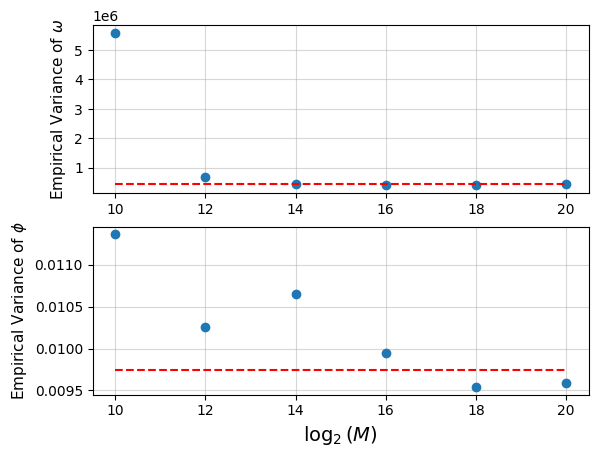

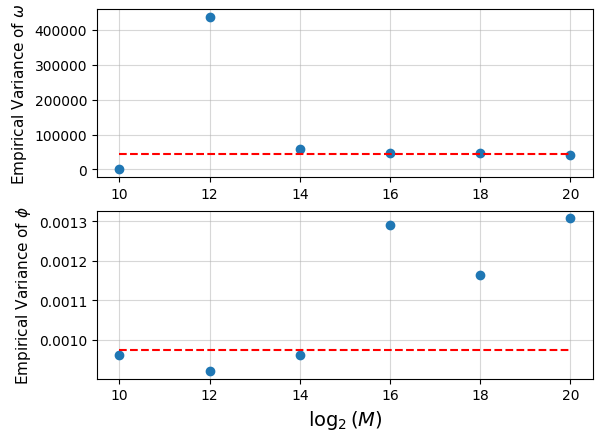

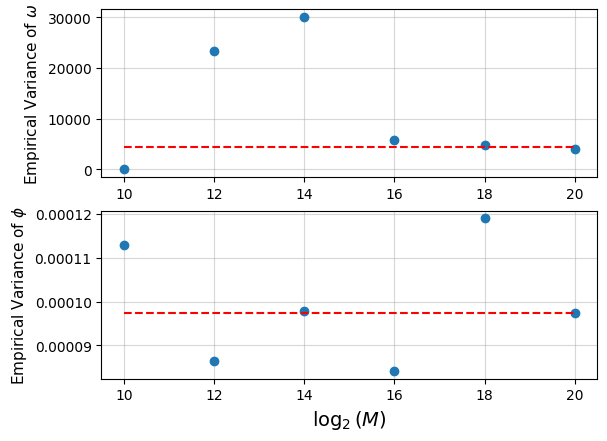

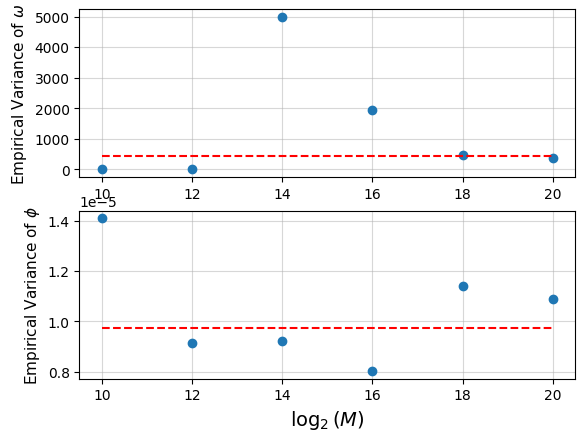

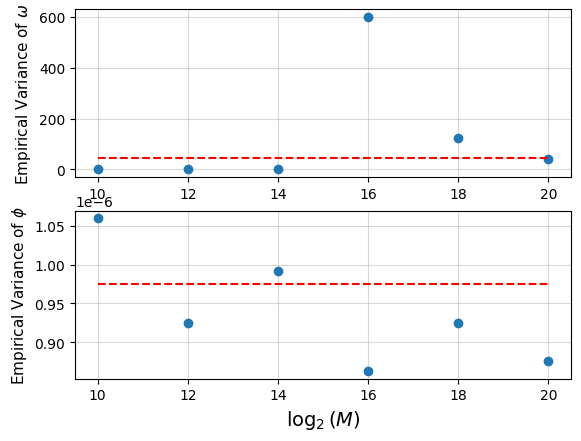

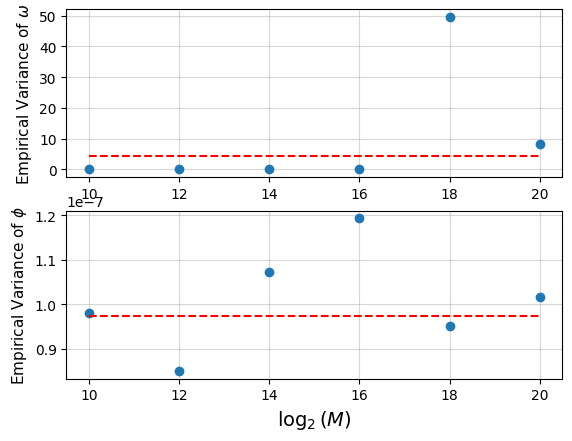

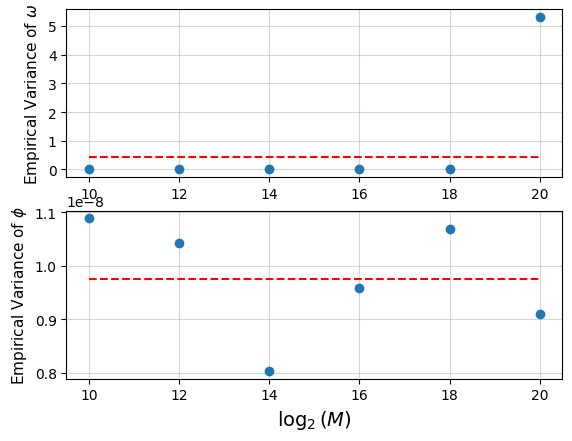

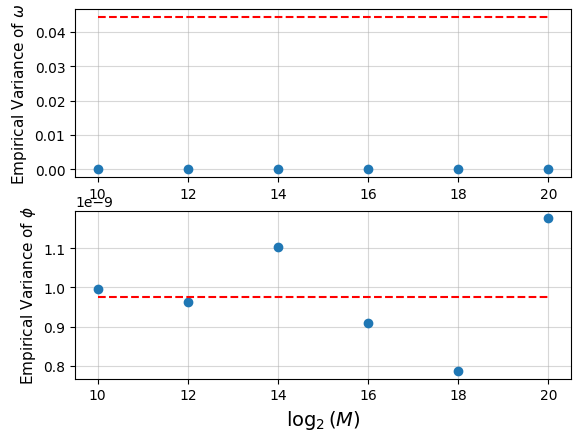

In [14]:
# Plotting
print(N)
crlb_omega = 12*(1/(2*SNR_num))/(T**2*N*(N+1)*(N-1))

P = N*(N-1)/2
Q = N*(N-1)*(2*N-1)/6

crlb_phi = (12*(1/(2*SNR_num))*(n_0**2*N+2*n_0*P+Q))/(N**2*(N-1)*(N+1))
for i, db in enumerate(SNR_db):
    plt.figure()
    plt.subplot(211)
    plt.plot(ks, var_omega[:,i], 'o')
    plt.plot(ks, crlb_omega[i]*np.ones(len(ks)), 'r--')
    plt.ylabel('Empirical Variance of $\omega$', fontsize=11)
    plt.grid(alpha=0.5)
    plt.subplot(212)
    plt.plot(ks, var_phi[:,i], 'o')
    plt.plot(ks, crlb_phi[i]*np.ones(len(ks)), 'r--')
    plt.ylabel('Empirical Variance of $\phi$', fontsize=11)
    plt.xlabel('$\log_2(M)$', fontsize=14)
    plt.grid(alpha=0.5)

In [1]:
# 1b)

m = 2**10

def objective(omega, signal):
    n = np.arange(N)
    return -np.abs((1/N)*np.sum(signal*np.exp(-1j*omega*n*T)))

def F_func(omega, signal):
    n = np.arange(N)
    return (1/N)*np.sum(signal*np.exp(-1j*omega*n*T))

for i, SNR in enumerate(SNR_num):
    temp_omega = np.zeros(1000)
    temp_phi = np.zeros(1000)
    for k in range(1000):
        noise_real = np.random.normal(0, A**2/(2*SNR), N)
        noise_complex = np.random.normal(0, A**2/(2*SNR), N)*1j
        signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
        F = fft.fft(signal, n=m, norm='ortho')
        m_star = np.argmax(np.abs(F))
        omega_hat = 2*np.pi*m_star/(m*T)
        phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
        res = scipy.optimize.minimize(objective, omega_hat, args=( signal),method='Nelder-Mead')
        omega_hat_new = res.x[0]
        phi_hat_new = np.angle(np.exp(-1j*omega_hat_new*n_0*T)*F_func(omega_hat_new, signal))
        temp_omega[k] = omega_hat_new - omega_0
        temp_phi[k] = phi_hat_new - phi
    print('SNR: ', SNR_db[i], 'omega: ', np.var(temp_omega, ddof=1)/crlb_omega[i], 'phi: ', np.var(temp_phi, ddof=1)/crlb_phi[i])
        

NameError: name 'SNR_num' is not defined

In [ ]:
SNR:  -10 omega:  4316241.789266655 phi:  69.39343574780862
SNR:  0 omega:  0.46906380639722556 phi:  0.5607111797985115
SNR:  10 omega:  0.056123291461226715 phi:  0.04956313117646759
SNR:  20 omega:  0.004961634806482271 phi:  0.004826151097995754
SNR:  30 omega:  0.0004153159631566961 phi:  0.0003962691533495992
SNR:  40 omega:  3.8345412693465115e-05 phi:  4.738391520586906e-05
SNR:  50 omega:  6.392559221966374e-06 phi:  4.383501156043354e-06
SNR:  60 omega:  4.626655196067391e-07 phi:  3.99049352146935e-07